In [24]:
import os

import pandas as pd
import torch
from IPython.display import display
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

In [51]:
torch.cuda.is_available()

True

In [11]:
class LinearModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(50, 1)

    def forward(self, x):
        return torch.relu(self.l1(x))

    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [99]:
def get_data(size):
  y = torch.randn((size, 1))
  embed_dim = torch.arange(50)
  x = torch.sin(embed_dim * y)
  return x,y
x,y = get_data(1000)

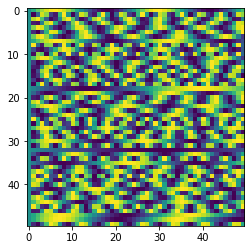

In [100]:
plt.imshow(x[:50])

In [101]:
class TabularDataset(Dataset):
  def __init__(self, x, y):
    self.x = x.detach().clone()
    self.y = y.detach().clone()
  def __len__(self):
    return len(self.x)
  def __getitem__(self,index):
    return self.x[index], self.y[index]

In [108]:
def get_dataloder(x,y, bs):
  NROWS = len(x)
  VALID_NROWS = NROWS // 10
  TRAIN_NROWS = NROWS - VALID_NROWS
  fullds = TabularDataset(x,y)
  trainds, valds = torch.utils.data.random_split(
    fullds, [TRAIN_NROWS, VALID_NROWS]
  )
  traindl = DataLoader(trainds,
                       shuffle=True,
                       batch_size = bs)
  valdl = DataLoader(valds,
                     shuffle=False,
                       batch_size = bs * 2)
  return traindl,valdl



In [123]:
def get_model(input_shape):
  model = nn.Sequential(
    nn.Linear(input_shape[-1], 1),
  )
  optimizer = torch.optim.Adam(model.parameters())
  return model, optimizer

crit = nn.MSELoss()

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 496.09it/s]


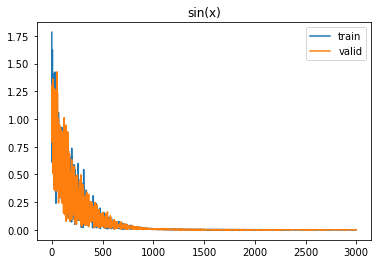

In [124]:
from tqdm import tqdm
EPOCHS = 1000
BATCH_SIZE = 32

x,y = get_data(100)
model, optimizer = get_model(x.shape)
traindl, valdl = get_dataloder(x,y,bs=32)

losses = {'train':[],'valid':[], 'meta': 'sin(x)'}
for ep in tqdm(range(EPOCHS)):
  model.train()
  for i,(xb,yb) in enumerate(traindl):
    optimizer.zero_grad()
    yhat = model(xb)
    loss = crit(yhat, yb)
    loss.backward()
    optimizer.step()
    losses['train'].append(loss.item())
  model.eval()
  with torch.no_grad():
    for i,(xb,yb) in enumerate(traindl):
      optimizer.zero_grad()
      yhat = model(xb)
      loss = crit(yhat, yb)
      losses['valid'].append(loss.item())

plt.figure()
plt.title(losses.pop('meta'))
for k,v in losses.items():
  x = range(len(v))
  plt.plot(x,v,label=k)
plt.legend()
plt.show()